# SNLP Assignment 5: Duplicate Question Detection
This notebook explores and compares various sentence transformer models and loss functions for detecting duplicate questions using the Quora dataset. Both bi-encoder and cross-encoder architectures are evaluated and their results are visualized.

**Section 1: Imports and Setup**
This section imports all the necessary libraries, sets up the environment, and selects the device (CPU or GPU) for running the models.

In [1]:
# Section 1: Imports and Setup
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  # Prevent transformers from importing TensorFlow
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from sentence_transformers.cross_encoder import CrossEncoder
from datasets import Dataset
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


**Section 2: Load and Prepare Data**
This section loads the Quora dataset, handles missing values, renames columns if needed, and splits the data into training, validation, and test sets. It also prepares the data in the format required for model training.

In [2]:
# Section 2: Load and Prepare Data
train_path = "train.csv"  # Update this path to your local file
df = pd.read_csv(train_path)
df = df.dropna(subset=["question1", "question2"])
if 'is_duplicate' in df.columns:
    df = df.rename(columns={"is_duplicate": "label"})
elif 'label' not in df.columns:
    raise ValueError("Dataset must have a 'label' or 'is_duplicate' column.")
print("Dataset shape:", df.shape)

# Split data
train_df, test_df = train_test_split(df, test_size=0.01, random_state=42, stratify=df["label"])  # Reduced test size for faster evaluation
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df["label"])
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

def make_examples(df):
    return [InputExample(texts=[q1, q2], label=float(label)) 
            for q1, q2, label in zip(df["question1"], df["question2"], df["label"])]

train_examples = make_examples(train_df)
val_examples = make_examples(val_df)
test_examples = make_examples(test_df)

Dataset shape: (404287, 6)
Train: 360219, Val: 40025, Test: 4043
Train: 360219, Val: 40025, Test: 4043


**Section 3: Helper Evaluation Functions**
This section defines functions to evaluate the bi-encoder and cross-encoder models using F1 score and accuracy. These functions are used to assess model performance throughout the notebook.

In [3]:
# Section 3: Helper Evaluation Functions
def evaluate_biencoder(model, examples, threshold=0.5):
    q1_emb = model.encode([ex.texts[0] for ex in examples], convert_to_tensor=True, device=device)
    q2_emb = model.encode([ex.texts[1] for ex in examples], convert_to_tensor=True, device=device)
    sims = util.cos_sim(q1_emb, q2_emb).diagonal()
    preds = (sims.cpu().numpy() > threshold).astype(int)
    labels = [int(ex.label) for ex in examples]
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return f1, acc

def evaluate_crossencoder(model, examples, threshold=0.5):
    pairs = [(ex.texts[0], ex.texts[1]) for ex in examples]
    scores = model.predict(pairs)
    preds = (scores > threshold).astype(int)
    labels = [int(ex.label) for ex in examples]
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return f1, acc

results = {}

**Section 4: Benchmark - Pretrained SBERT**
This section evaluates a pretrained Sentence-BERT (SBERT) model on the test set as a baseline. The results serve as a reference for comparison with fine-tuned models.

In [5]:
# Section 4: Benchmark - Pretrained SBERT
model_bench = SentenceTransformer("all-MiniLM-L6-v2", device=device)
f1, acc = evaluate_biencoder(model_bench, test_examples)
results["Benchmark (SBERT pretrained)"] = (f1, acc)
print("Benchmark SBERT F1:", f1)

c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Benchmark SBERT F1: 0.6441850410722006


**Section 5: Bi-Encoder with Cosine Similarity Loss**
This section fine-tunes a bi-encoder model using cosine similarity loss on a subset of the training data. The model's performance is then evaluated on the test set.

In [ ]:
# Section 5: Bi-Encoder with Cosine Similarity Loss
train_df_small = train_df.sample(5000, random_state=42)  # Reduced for faster execution
train_examples_small = make_examples(train_df_small)
train_dataloader = DataLoader(train_examples_small, shuffle=True, batch_size=32)
epochs = 1
warmup = 50
model_cosine = SentenceTransformer("all-MiniLM-L6-v2", device=device)
train_loss = losses.CosineSimilarityLoss(model_cosine)
model_cosine.fit(train_objectives=[(train_dataloader, train_loss)], epochs=epochs, warmup_steps=warmup, show_progress_bar=True)
f1, acc = evaluate_biencoder(model_cosine, test_examples)
results["Bi-Encoder (Cosine Loss)"] = (f1, acc)
print("Cosine Loss F1:", f1)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Cosine Loss F1: 0.7287113200156679


**Section 6: Bi-Encoder with Contrastive Loss**
This section fine-tunes a bi-encoder model using contrastive loss, which encourages the model to bring similar pairs closer and push dissimilar pairs apart in the embedding space. The model is evaluated on the test set.

In [ ]:
# Section 6: Bi-Encoder with Contrastive Loss
train_dataloader = DataLoader(train_examples_small, shuffle=True, batch_size=32)
model_contrast = SentenceTransformer("all-MiniLM-L6-v2", device=device)
train_loss = losses.ContrastiveLoss(model_contrast)
model_contrast.fit(train_objectives=[(train_dataloader, train_loss)], epochs=epochs, warmup_steps=warmup, show_progress_bar=True)
f1, acc = evaluate_biencoder(model_contrast, test_examples)
results["Bi-Encoder (Contrastive Loss)"] = (f1, acc)
print("Contrastive Loss F1:", f1)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


Contrastive Loss F1: 0.6577948446327684


**Section 7: Bi-Encoder with Multiple Negatives Ranking Loss**
This section fine-tunes a bi-encoder model using Multiple Negatives Ranking Loss (MNRL), which is effective for retrieval tasks. The model is then evaluated on the test set.

In [ ]:
# Section 7: Bi-Encoder with Multiple Negatives Ranking Loss
train_dataloader = DataLoader(train_examples_small, shuffle=True, batch_size=32)
model_mnrl = SentenceTransformer("all-MiniLM-L6-v2", device=device)
train_loss = losses.MultipleNegativesRankingLoss(model_mnrl)
model_mnrl.fit(train_objectives=[(train_dataloader, train_loss)], epochs=epochs, warmup_steps=warmup, show_progress_bar=True)
f1, acc = evaluate_biencoder(model_mnrl, test_examples)
results["Bi-Encoder (MNRL)"] = (f1, acc)
print("MNRL Loss F1:", f1)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


MNRL Loss F1: 0.6475921295793021


**Section 8: Cross-Encoder**
This section fine-tunes a cross-encoder model, which jointly encodes both questions in a pair and directly predicts their similarity. The model is trained and evaluated on the test set.

In [ ]:
# Section 8: Cross-Encoder
train_data = [InputExample(texts=[row.question1, row.question2], label=row.label) for _, row in train_df_small.iterrows()]
val_data = [InputExample(texts=[row.question1, row.question2], label=row.label) for _, row in val_df.iterrows()]
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
model_cross = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", num_labels=1, device=device)
model_cross.fit(train_dataloader=train_dataloader, evaluator=None, epochs=1, warmup_steps=50, show_progress_bar=True)
f1, acc = evaluate_crossencoder(model_cross, test_examples)
results["Cross-Encoder"] = (f1, acc)
print("Cross-Encoder F1:", f1)

c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


Cross-Encoder F1: 0.7303269737264727


**Section 9: Final Comparison**
This section compares the F1 scores and accuracy of all evaluated models and visualizes the results using a horizontal bar chart.


=== Final Comparison (F1, Accuracy) ===
Bi-Encoder (Cosine Loss): F1=0.7287, Accuracy=0.7430
Bi-Encoder (Contrastive Loss): F1=0.6578, Accuracy=0.6165
Bi-Encoder (MNRL): F1=0.6476, Accuracy=0.5991
Cross-Encoder: F1=0.7303, Accuracy=0.7923
Benchmark (SBERT pretrained): F1=0.6442, Accuracy=0.5927


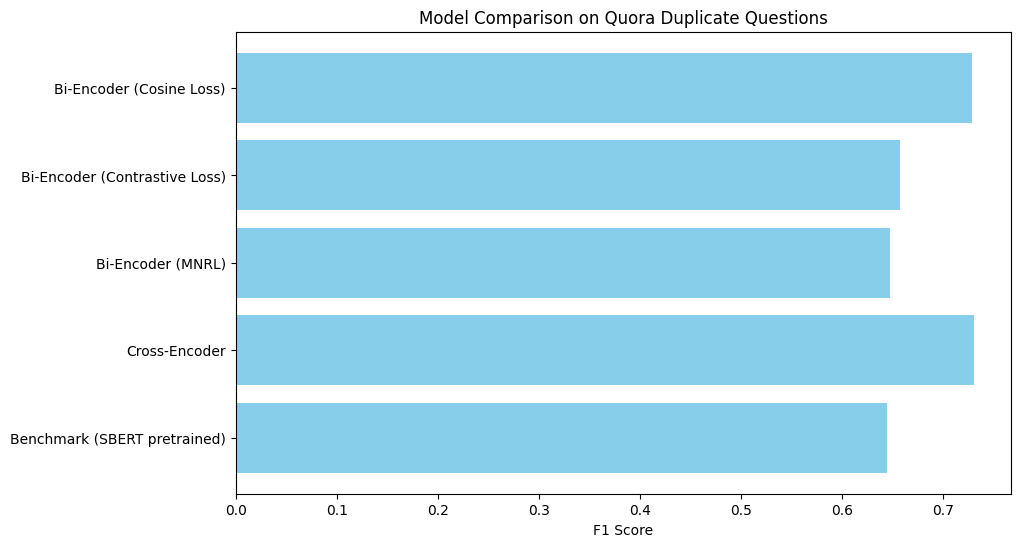

In [ ]:
# Section 9: Final Comparison
print("\n=== Final Comparison (F1, Accuracy) ===")
for model_name, (f1, acc) in results.items():
    print(f"{model_name}: F1={f1:.4f}, Accuracy={acc:.4f}")

labels = list(results.keys())
f1_scores = [v[0] for v in results.values()]
plt.figure(figsize=(10,6))
plt.barh(labels, f1_scores, color="skyblue")
plt.xlabel("F1 Score")
plt.title("Model Comparison on Quora Duplicate Questions")
plt.gca().invert_yaxis()
plt.show()

# Conclusion
In this notebook, we compared several sentence transformer models and loss functions for the task of duplicate question detection. The results show the impact of different training objectives and architectures (bi-encoder vs. cross-encoder) on model performance. Cross-encoders generally achieve higher accuracy but are slower at inference, while bi-encoders are more efficient for large-scale retrieval. The visual comparison helps in selecting the best approach for practical applications.